# Overfitting y Underfitting

## Objetivos

- Comprender qué es el **overfitting** (sobreajuste) y el **underfitting** (subajuste)
- Identificar visualmente estos fenómenos en curvas de entrenamiento
- Aplicar técnicas para prevenir overfitting en Pytorch

## Importar librerías

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from utils import *
torch.manual_seed(42)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


## Demostración Underfitting vs Overfitting

La **funcion peaks** es una superficie tridimensional compleja basada en distribuciones gaussianas. 
<center>
<pre><code class="language-python">
y = peaks(x1, x2)
</code></pre>
</center>

<center><img src="https://www.researchgate.net/profile/Sergiy-Reutskiy/publication/257397025/figure/fig2/AS:798646559862785@1567423586780/The-PEAKS-function-F2x.png" width="400"></center>

Para aproximarla, utilizaremos dos modelos de redes neuronales:
1. **Modelo pequeño** (8 → 1): Probablemente underfitting
2. **Modelo grande** (128 → 64 → 32 → 1): Probablemente overfitting

In [2]:
class SmallModel(nn.Module):
    """Modelo pequeño para observar subajuste o underfitting"""
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        return self.net(x)

class LargeModel(nn.Module):
    """Modelo grande para trabajar el sobreajuste o overfitting"""
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

Al tratarse de una tarea de regresión, la *loss fuction* elegida es **MSE**. Como algoritmo de optimización, se ha seleccionado **Adam** manteniendo el *learning rate* fijo durante el proceso de entrenamiento.

In [3]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.01):
    """
    Función para entrenar modelos.
    """
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in tqdm(range(epochs), desc="Training loop"):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Training
            y_pred = model(X_batch)
            loss = loss_fcn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        val_loss = 0
        model.eval()
        for X_batch, y_batch in val_loader:
            with torch.no_grad():
                y_pred_val = model(X_batch)
                loss = loss_fcn(y_pred_val, y_batch)

                val_loss += loss
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
    
    return history

Para poder visualizar el fenómeno del sobreajuste u overfitting, emplearemos un dataset con elevados niveles de ruido y con insuficientes datos de entrenamiento.

La función `prepare_dataset(...)` devuelve directamente dos objetos de tipo DataLoader (uno de entrenamiento y otro de validación), para entrenar nuestros modelos con Pytorch.

(<Figure size 1200x600 with 1 Axes>,
 <Axes3D: xlabel='X1', ylabel='X2', zlabel='Z'>)

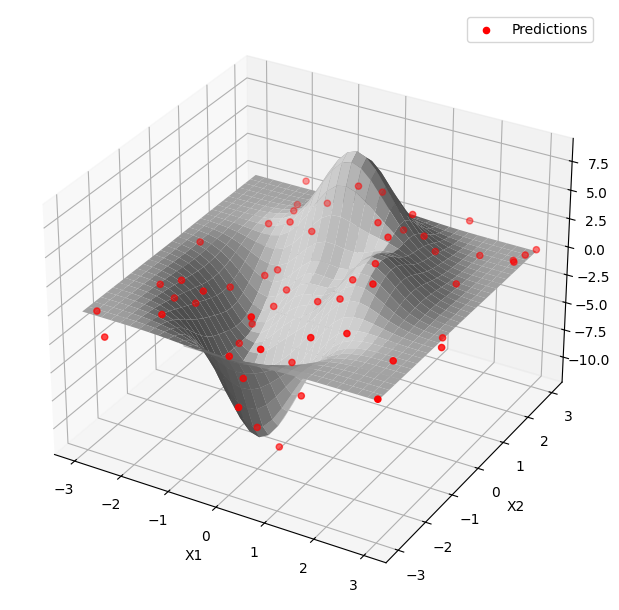

In [6]:
NOISE = 2.
TRAIN_RATIO = 0.3
N_SAMPLES = 200
BATCH_SIZE = int(TRAIN_RATIO*N_SAMPLES/2)

peaks = PeaksFunction()
train_loader, val_loader = peaks.prepare_dataset(n_samples=N_SAMPLES, test_size=(1-TRAIN_RATIO), batch_size=BATCH_SIZE, noise=NOISE)
peaks.plot_scatter()

A continuación, observa lo que ocurre al entrenar ambos modelos durante 500 épocas y con un *learning rate* de 0.005.

In [ ]:
EPOCHS = 500
LR = 0.005

# Entrenar modelo pequeño (underfitting moderado)
input_size = train_loader.dataset.tensors[0].shape[1]
device = train_loader.dataset.tensors[0].device
small = SmallModel(input_size).to(device)
history_small = train_model(small, train_loader, val_loader, epochs=EPOCHS, lr=LR)

print(f"\nTrain loss final: {history_small['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_small['val_loss'][-1]:.4f}")

# Entrenar modelo grande (overfitting)
large = LargeModel(input_size).to(device)
history_large = train_model(large, train_loader, val_loader, epochs=EPOCHS, lr=LR)

print(f"\nTrain loss final: {history_large['train_loss'][-1]:.4f}")
print(f"Val loss final: {history_large['val_loss'][-1]:.4f}")

# Representar curvas de aprendizaje
plot_learning_curve_comparison(history_small, history_large)

# Visualizar predicciones de ambos modelos
fig_small = peaks.plot_predictions_surface(small, device, n_points=50, title='Modelo Pequeño (Underfitting)')
fig_large = peaks.plot_predictions_surface(large, device, n_points=50, title='Modelo Grande (Overfitting)')

## Estrategias para prevenir el overfitting

### Early Stopping

In [ ]:
def train_model2(model, train_loader, val_loader, epochs=200, lr=0.01, early_stopping=False, patience=20, min_delta=0.001):
    """
    Función para entrenar modelos.
    
    Parámetros:
        early_stopping: Si True, detiene cuando val_loss no mejora
        patience: Cuántas épocas esperar sin mejora
        min_delta: mínimo cambio en la función objetivo que se considera mejora
    """
    loss_fcn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    history = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in tqdm(range(epochs), desc="Training loop"):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Training
            y_pred = model(X_batch)
            loss = loss_fcn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validation
        val_loss = 0
        model.eval()
        for X_batch, y_batch in val_loader:
            with torch.no_grad():
                y_pred_val = model(X_batch)
                loss = loss_fcn(y_pred_val, y_batch)

                val_loss += loss
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Early stopping
        if early_stopping:
            if val_loss.item() < best_val_loss - min_delta:
                best_val_loss = val_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping en época {epoch}")
                    break
        
        # if (epoch + 1) % 50 == 0:
        #     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return history